In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveDrift, ExponentialSmoothing, TBATS, AutoARIMA, Theta
from darts.utils.statistics import plot_residuals_analysis
from darts.metrics import mape

c:\Users\Ayden\venvs\ml39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODELS = {}

def quick_plot(ts_all, label):
    ts_all.drop_before(pd.Timestamp('2022-01-01')).plot(label='acutal')
    MODELS[label][1].plot(label=label)

def get_results(test):
    return pd.DataFrame([{'model': m, 'mape': mape(test, MODELS[m][1])} for m in MODELS]).sort_values('mape').reset_index(drop=True)

def quick_train_and_fc(model, label, train, test):
    model.fit(train)
    forecast = model.predict(len(test))
    MODELS[label] = [model, forecast]

### Data Import

In [8]:
cutoff = '2023-01-01'
start_date = '2016-08-31'

In [6]:
df_all = pd.read_csv('../data.csv', index_col=0)

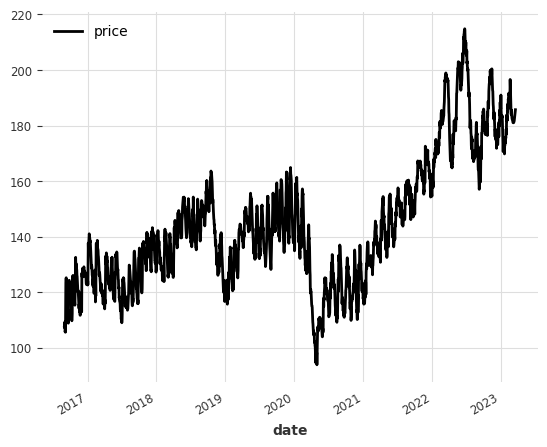

In [9]:
ts_all = TimeSeries.from_dataframe(df_all.reset_index(drop=True), time_col='date').drop_before(pd.Timestamp(start_date))
ts_all.plot()

In [10]:
train, test = ts_all.split_before(pd.Timestamp(cutoff))

### Naive Models

In [11]:
MODELS = {}

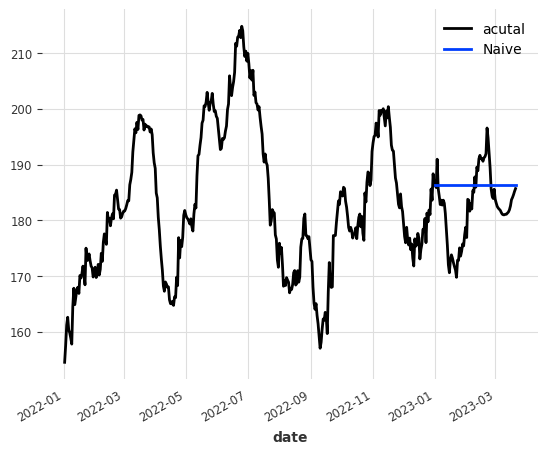

In [13]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(test))

MODELS['Naive'] = [naive_model, naive_forecast]

quick_plot(ts_all, 'Naive')

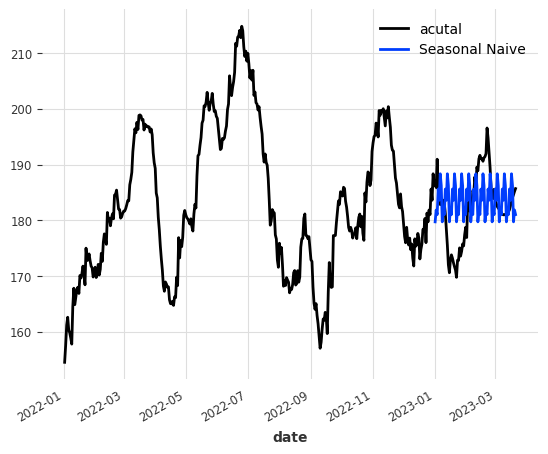

In [14]:
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(test))

MODELS['Seasonal Naive'] = [seasonal_model, seasonal_forecast]

quick_plot(ts_all, 'Seasonal Naive')

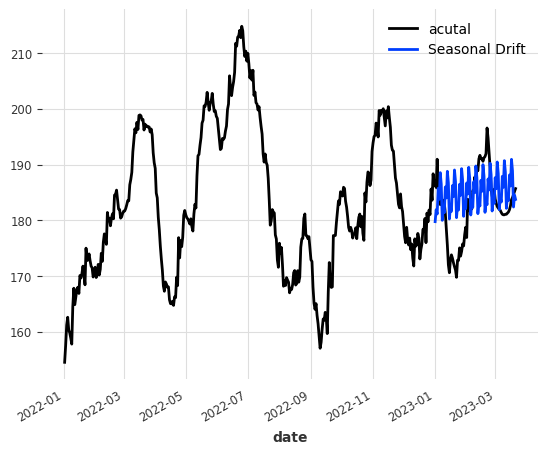

In [15]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(test))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

MODELS['Seasonal Drift'] = [None, combined_forecast]

quick_plot(ts_all, 'Seasonal Drift')


### Simple Models

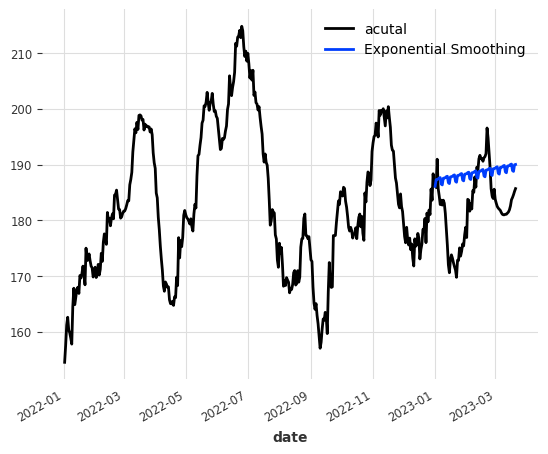

In [17]:
quick_train_and_fc(ExponentialSmoothing(), 'Exponential Smoothing', train, test)
quick_plot(ts_all, 'Exponential Smoothing')

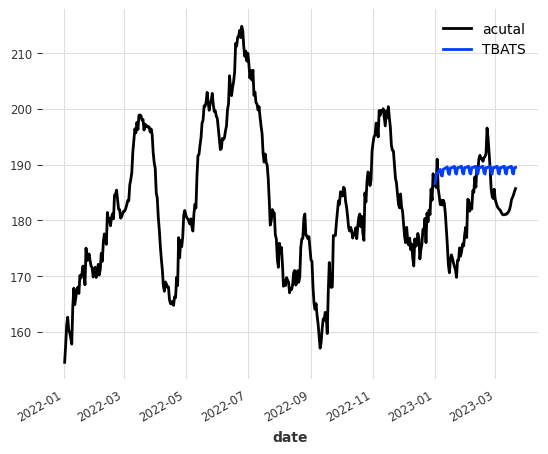

In [19]:
quick_train_and_fc(TBATS(), 'TBATS', train, test)
quick_plot(ts_all, 'TBATS')

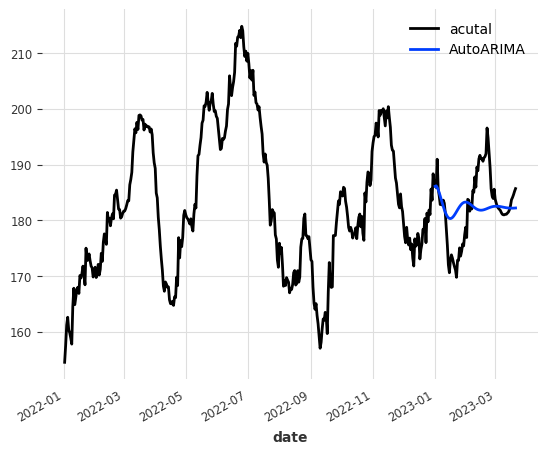

In [20]:
quick_train_and_fc(AutoARIMA(), 'AutoARIMA', train, test)
quick_plot(ts_all, 'AutoARIMA')

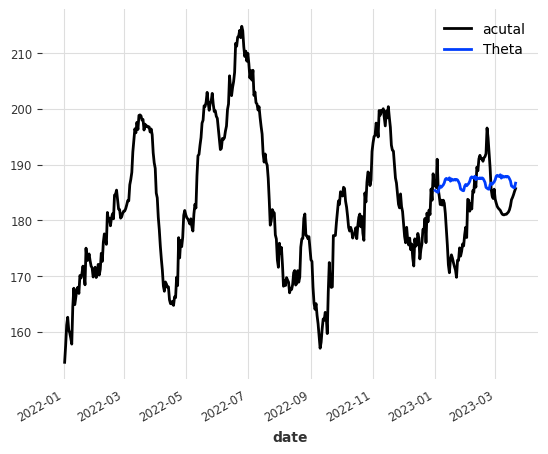

In [22]:
quick_train_and_fc(Theta(), 'Theta', train, test)
quick_plot(ts_all, 'Theta')

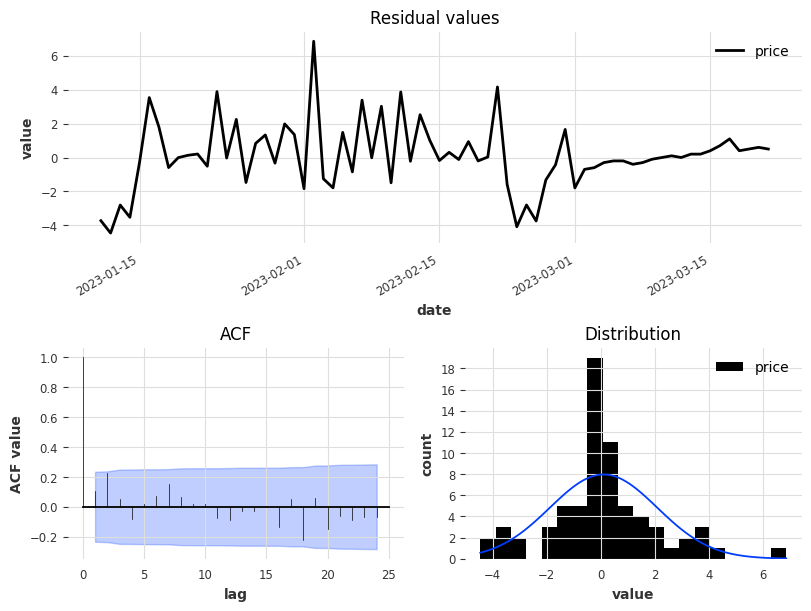

In [29]:
plot_residuals_analysis(MODELS['AutoARIMA'][0].residuals(test))

In [24]:
get_results(test)

,model,mape
0,AutoARIMA,2.477594
1,Seasonal Naive,3.129548
2,Naive,3.249749
3,Seasonal Drift,3.265358
4,Theta,3.509929
5,Exponential Smoothing,3.942588
6,TBATS,4.230220


### Modelling Approach
- CV Approach
    - Train a model that becomes very good at producing 1-week and 2-week probabilistic forecasts
- Introduce past covariates
- Potentially forecast the 1 week and 2 week figure as opposed to the days between

## CV Approach

- RandomForest
- LightGBM
- XGBModel
- ARIMA

In [32]:
test

<TimeSeries (DataArray) (date: 80, component: 1, sample: 1)>
array([[[187.1340824 ]],

       [[185.90120968]],

       [[190.97466667]],

       [[185.69950083]],

       [[184.39216867]],

       [[182.83609959]],

       [[183.62795181]],

       [[182.7419598 ]],

       [[183.62460882]],

       [[183.08254818]],

...

       [[181.1       ]],

       [[181.3       ]],

       [[181.5       ]],

       [[181.9       ]],

       [[182.6       ]],

       [[183.7       ]],

       [[184.1       ]],

       [[184.6       ]],

       [[185.2       ]],

       [[185.7       ]]])
Coordinates:
  * date       (date) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-03-21
  * component  (component) object 'price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [36]:
hfc = MODELS['AutoARIMA'][0].historical_forecasts(test, forecast_horizon=7, stride=7, start=pd.Timestamp('2023-01-15'), last_points_only=False)

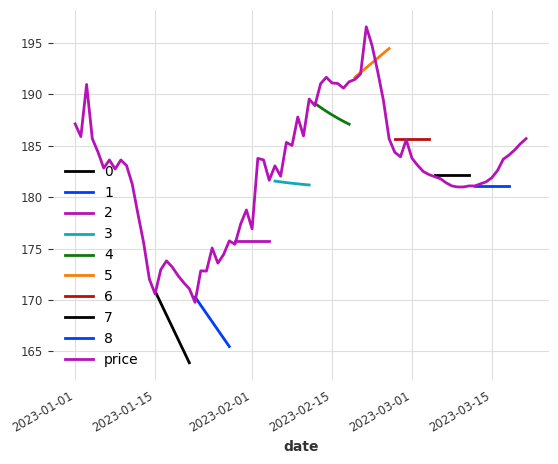

In [45]:
for i, f in enumerate(hfc):
    f.plot(label=str(i))
test.plot()